In [20]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
from scipy.fftpack import fft, fftfreq
from scipy.signal import firwin, lfilter

In [21]:
def fir_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b = firwin(order, normal_cutoff)
    return b
    
def fir_lowpass_filter(data, cutoff, fs, order=5):
    b = fir_lowpass(cutoff, fs, order=order)
    y = lfilter(b, 1.0, data)
    return b, y

def write_hex_coe(f_name, h):
    """
    Function for converting float array to hex and writing to Xilinx coe file
    f_name  - name of output file ("LPF.coe")
    h       - normalized float array (-1 ... 1)
    """
    if os.path.exists(f_name):
        os.remove(f_name)
        
    if (np.max(h) > 1) | (np.min(h) < -1):
        sys.exit("Error: Input array exceed 1 or -1")
        
    h = np.round(2**15 * h).astype('int')
    with open(f_name, 'a') as fp:
        fp.write('radix=16;\n')
        fp.write('CoefData=\n')
        for k in range(np.size(h)):
            if h[k] >= 0:
                h_16 = hex(h[k])
                if   len(h_16) == 3:fp.write('000')
                elif len(h_16) == 4:fp.write('00')
                elif len(h_16) == 5:fp.write('0')
            else:
                h[k] = 2**16 - abs(h[k])
                h_16 = hex(h[k])
            fp.write(h_16[2:])
            if k < np.size(h)-1: fp.write(',\n')
            else:fp.write(';')

def graficar_t(tiempo, senial_t, titulo, color = None):
    """
    Funcion que grafica una señal en funcion del tiempo.
    Entradas:
             tiempo: vector del eje del tiempo
             senial_t: vector que contiene la señal a graficar
             titulo: titulo de la grafica
    Salidas:
             Grafica la señal en funcion del tiempo.
    """
    if color is None: color = "b"
    else: color = color
    plt.plot(tiempo, senial_t, color, label = titulo)
    plt.xlabel('Tiempo [s]')
    plt.ylabel('Amplitud')
    plt.legend()
    
def respuesta_frecuencia_filtro(coeficientes, frecuencia_corte, frecuencia_muestreo, titulo, color = None):
    if color is None: color = "b"
    else: color = color
    espectro = fft(coeficientes)
    frecuencias = fftfreq(len(espectro), (1 / frecuencia_muestreo))
    frecuencias_positivas = frecuencias[:len(frecuencias) // 2]
    espectro_positivo = np.abs(espectro[:len(frecuencias) // 2])
    espectro_positivo = 10 * np.log10(espectro_positivo)
    plt.plot(frecuencias_positivas, espectro_positivo, color, label = titulo)
    plt.xlabel('Frecuencia [Hz]')
    plt.ylabel('Magnitud [dB]')
    plt.axvline(x=frecuencia_corte, color='g', linestyle='--', label=f'Frecuencia de corte ={frecuencia_corte} [Hz]')
    plt.legend()
    plt.grid(True)

In [22]:
# Parámetros del filtro
order = 35
fs = 100.0e6  # Tasa de muestreo, Hz
cutoff_freq = 8e6  # Frecuencia de corte, Hz

# Generar señal de entrada
T = 10e-6  # segundos
F1 = 1e6
F2 = 18e6
n = int(T * fs)  # número total de muestras
t = np.linspace(0, T, n, endpoint=False)
s = np.cos(2 * np.pi * t * (F1 + (F2 - F1) / T / 2 * t))

# Aplicar filtro pasa bajos FIR a la señal de entrada
coeficientes, s_postLPF = fir_lowpass_filter(s, cutoff_freq, fs, order)

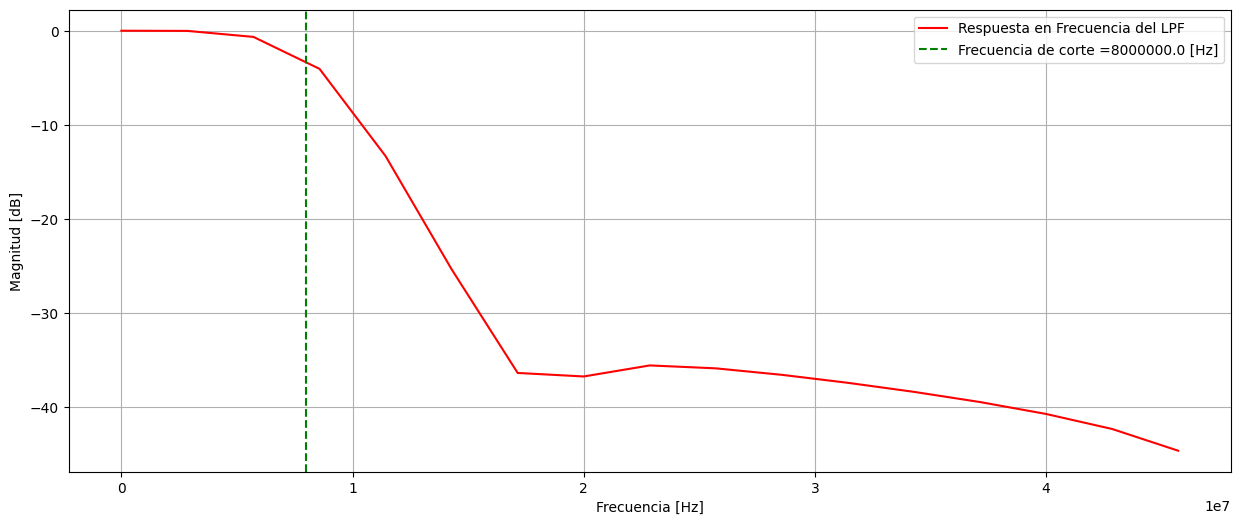

In [23]:
plt.figure(figsize=(15, 6))
respuesta_frecuencia_filtro(coeficientes, cutoff_freq,fs, "Respuesta en Frecuencia del LPF", 'r')
#plt.axis([0,1,None,None])
plt.show()

In [ ]:


plt.figure(figsize=(10, 6))

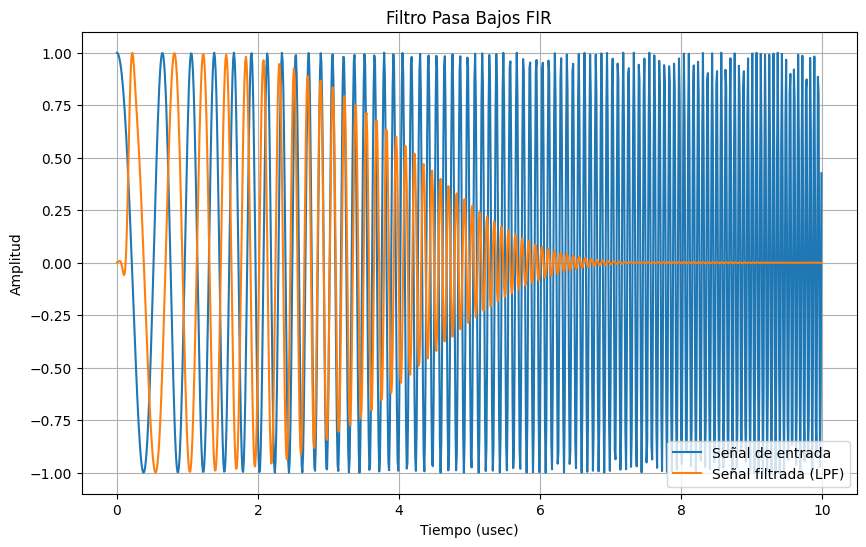

In [24]:

# Graficar la señal de entrada y la señal filtrada
plt.figure(figsize=(10, 6))
plt.plot(t/1e-6, s, label='Señal de entrada')
plt.plot(t/1e-6, s_postLPF, label='Señal filtrada (LPF)')
plt.title('Filtro Pasa Bajos FIR')
plt.xlabel('Tiempo (usec)')
plt.ylabel('Amplitud')
plt.grid()
plt.legend()
plt.show()

In [25]:
# Escribir coeficientes del filtro FIR en archivo .coe
write_hex_coe('files/fir_LPF.coe', coeficientes)